In [14]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,StratifiedKFold,RepeatedStratifiedKFold, cross_validate
from copy import deepcopy

from time import time
from sklearn.preprocessing import FunctionTransformer

In [15]:
def train_model(list_model,X_train,y_train,X_test,y_test,metric,cv,scorer,pipeline):
    df_model = pd.DataFrame(columns = ["model_name","set_data","score","model"])
    set_data = ["test","cv","train"]

    for m in list_model: 
        pipeline_copy = deepcopy(pipeline)
        pipeline_copy.set_params(model = list_model[m])
        spot_check = cross_val_score(pipeline_copy,X_train,y_train,cv = cv,scoring = scorer,n_jobs= -1)
        spot_check_acc = cross_val_score(pipeline_copy,X_train,y_train,cv = cv,scoring = "accuracy",n_jobs= -1)
        spot_check = spot_check.mean()
        spot_check_acc = spot_check_acc.mean()
        model = pipeline_copy.fit(X_train,y_train)
        score = metric(y_test,model.predict(X_test),average = "macro")
        score_train = metric(y_train,model.predict(X_train),average = "macro")
        acc_score = model.score(X_test,y_test)
        model_list = [m] * 3
        tes = pd.DataFrame(list(zip(model_list,set_data,[score,spot_check,score_train],[model,model,model])),columns = ["model_name","set_data","score","model"])
        print(f"model {m} selesai di training")
        print(f"score test {score}")
        print(f"score cv {spot_check}")
        print(f"score train {score_train}")
        print(f"acc score test {acc_score}")
        print(f"acc score cv {spot_check_acc}")
        print("=====================================")
        df_model = pd.concat([df_model,tes],ignore_index = True)
        
    return df_model

def rfecv(X, y, pipeline,min_features_to_select=3, cv = 3,step=3,scoring_metric="f1",scoring_decimals=3,random_state=42,groups = None):
    # Initialize survivors and ranked list
    estimator = deepcopy(pipeline)
    estimator.steps.pop(-1)
    survivors = estimator.fit_transform(X,y).columns.tolist()
    ranks = []
    scores = []
    while len(survivors) >= min_features_to_select:
        remove_column_transformer = FunctionTransformer(lambda x: x.drop(ranks, axis=1))
        estimator = deepcopy(pipeline)
        estimator.steps.insert(-1, ('remove_column_transformer', remove_column_transformer))
        print("[%.2f] evaluating %i features ..." % (time(), len(survivors)))
        cv_result = cross_validate(estimator, X, y,
                                cv=cv,
                                groups = groups,
                                scoring=scoring_metric,
                                return_estimator=True)
        score = np.mean(cv_result["test_score"])
        if scoring_decimals is None:
            scores.append(score)
        else:
            scores.append(round(score, scoring_decimals))            
        print("[%.2f] ... score %f." % (time(), scores[-1]))
        
        best_estimator = cv_result["estimator"][np.argmax(cv_result["test_score"])]
        if isinstance(best_estimator, Pipeline):
            weights = best_estimator[-1].feature_importances_
        else:
            weights = best_estimator.feature_importances_
        weights = list(np.power(weights, 2))
        for _ in range(max(min(step, len(survivors) - min_features_to_select), 1)):
            idx = np.argmin(weights)
            ranks.insert(0, survivors.pop(idx))
            weights.pop(idx)
    ranks_reverse = list(reversed(ranks))
    last_max_idx = len(scores) - np.argmax(list(reversed(scores))) - 1
    removed_features = set(ranks_reverse[0:last_max_idx * step])
    best_features = [f for f in X.columns if f not in removed_features]
    return best_features, max(scores), ranks, scores

In [16]:
ROOT = '../'

In [17]:
df = pd.read_csv(ROOT + 'dataset/data.csv')
#drop last column
df = df.iloc[:, :-1]
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df_all_features = df.iloc[:,1:].copy()
features_name= list(df_all_features.columns)[1:]
df_all_features.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
def correlation(dataset, threshold):
    df_corr = dataset.corr(method="pearson")
    columns = np.full((df_corr.shape[0],), True, dtype=bool)
    for i in range(df_corr.shape[0]):
        for j in range(i+1, df_corr.shape[0]):
            if df_corr.iloc[i,j] >= threshold:
                if columns[j]:
                    columns[j] = False
    selected_columns = df_corr.columns[columns]
    return list(selected_columns)
uncorr_features = correlation(df[features_name],0.9)
print(uncorr_features)
print(len(uncorr_features))

['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']
20


Text(0.5, 0, 'Diagnosis')

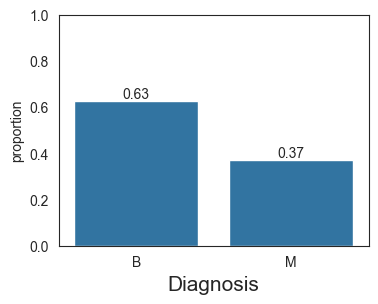

In [10]:
#plot distribution of diagnosis
df_proportion = df_all_features.diagnosis.value_counts(normalize=True).to_frame().reset_index()
plt.figure(figsize = (4,3))
sns.set_style("white")
sns.barplot(x = "diagnosis",y = "proportion",data = df_proportion)
#add data labels
for i in range(df_proportion.shape[0]):
    count = df_proportion.iloc[i,1]
    plt.text(i,count+0.01,round(count,2),ha = "center")
plt.ylim(0,1)
plt.xlabel("Diagnosis",fontsize = 15)

In [11]:
    ## stratified shuffle
X = df_all_features.drop(columns="diagnosis")[uncorr_features]
y = df_all_features["diagnosis"]
#replace M and B with 1 and 0
y = y.replace({"M":1,"B":0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((426, 20), (143, 20), (426,), (143,))

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
   ("numerical",num_pipe,uncorr_features)
],remainder = "drop",verbose_feature_names_out=False).set_output(transform = "pandas")

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("preprocess",preprocessor),
    ("model",None)
])

list_model = {
    "rf":RandomForestClassifier(random_state=42),
}

from sklearn.metrics import f1_score,make_scorer
f1_scorer = make_scorer(f1_score,average = "macro")

cv = StratifiedKFold(n_splits=5,shuffle=False)
df_model = train_model(list_model,X_train,y_train,X_test,y_test,f1_score,cv,f1_scorer,pipeline)

model rf selesai di training
score test 0.9617340112389617
score cv 0.9520714064942579
score train 1.0
acc score test 0.965034965034965
acc score cv 0.9553488372093024


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_12076\4062481733.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model = pd.concat([df_model,tes],ignore_index = True)


In [26]:
rf_model = df_model.model.values[0]
from sklearn.metrics import classification_report
print(classification_report(y_test,rf_model.predict(X_test),digits=4))

              precision    recall  f1-score   support

           0     0.9474    1.0000    0.9730        90
           1     1.0000    0.9057    0.9505        53

    accuracy                         0.9650       143
   macro avg     0.9737    0.9528    0.9617       143
weighted avg     0.9669    0.9650    0.9646       143



In [36]:
pipeline_rf = Pipeline([
    ("preprocess",preprocessor),
    ("algo",RandomForestClassifier(random_state=42))
])
rfe_rf = rfecv(X_train,y_train,pipeline_rf,step = 1,cv = cv,scoring_metric=f1_scorer,scoring_decimals=4,random_state=42)

[1698247990.84] evaluating 20 features ...
[1698247991.88] ... score 0.952100.
[1698247991.89] evaluating 19 features ...
[1698247992.97] ... score 0.944200.
[1698247992.98] evaluating 18 features ...
[1698247994.05] ... score 0.952000.
[1698247994.05] evaluating 17 features ...
[1698247995.00] ... score 0.956700.
[1698247995.00] evaluating 16 features ...
[1698247995.98] ... score 0.951900.
[1698247995.99] evaluating 15 features ...
[1698247996.93] ... score 0.946800.
[1698247996.94] evaluating 14 features ...
[1698247997.94] ... score 0.952000.
[1698247997.94] evaluating 13 features ...
[1698247998.87] ... score 0.951600.
[1698247998.87] evaluating 12 features ...
[1698247999.80] ... score 0.946700.
[1698247999.80] evaluating 11 features ...
[1698248000.77] ... score 0.946500.
[1698248000.78] evaluating 10 features ...
[1698248001.90] ... score 0.941800.
[1698248001.91] evaluating 9 features ...
[1698248002.75] ... score 0.931600.
[1698248002.75] evaluating 8 features ...
[1698248003

In [39]:
rfe_rf[1]
print(rfe_rf[0])

['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'symmetry_worst']


In [41]:
drop_cols_rf = [col for col in X_train.columns if col not in rfe_rf[0]]
print(drop_cols_rf)

['texture_se', 'smoothness_se', 'fractal_dimension_worst']


In [44]:
pipeline_rf_rfe = Pipeline([
    ("preprocess",preprocessor),
    ("drop_cols",FunctionTransformer(lambda x: x.drop(drop_cols_rf,axis = 1))),
    ('model',None)
])
list_model = {
    "rf":RandomForestClassifier(random_state=42),
}
df_model_rfe = train_model(list_model,X_train,y_train,X_test,y_test,f1_score,cv,f1_scorer,pipeline_rf_rfe)

model rf selesai di training
score test 0.9620669531540135
score cv 0.9567408878062753
score train 1.0
acc score test 0.965034965034965
acc score cv 0.9600547195622436


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_12076\4062481733.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model = pd.concat([df_model,tes],ignore_index = True)


In [46]:
print(classification_report(y_test,df_model_rfe.model.values[0].predict(X_test),digits=4))

              precision    recall  f1-score   support

           0     0.9570    0.9889    0.9727        90
           1     0.9800    0.9245    0.9515        53

    accuracy                         0.9650       143
   macro avg     0.9685    0.9567    0.9621       143
weighted avg     0.9655    0.9650    0.9648       143



In [47]:
import optuna
from sklearn.metrics import classification_report

def tuning_model(objective,pipeline,n_trial = 100):
    study = optuna.create_study(direction="maximize")
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=n_trial,show_progress_bar=True,)
    best_params = study.best_params
    pipeline.set_params(**best_params)
    pipeline.fit(X_train, y_train)
    test_score = f1_score(y_test, pipeline.predict(X_test),average = "macro")
    train_score = f1_score(y_train, pipeline.predict(X_train),average = "macro")
    valid_score = study.best_value
    y_pred = pipeline.predict(X_test)
    print("best params:", best_params)
    print("train score:", train_score)
    print("test score:", test_score)
    print("valid score:", valid_score)
    print(classification_report(y_test, y_pred,digits=5))
    return pipeline

d:\conda\envs\breast-cancer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
pipeline_rf = Pipeline([
    ('prep',preprocessor),
    ('algo',RandomForestClassifier(random_state=42))
])

def objective(trial):
    n_estimators = trial.suggest_int('algo__n_estimators',100,300,step = 100)
    min_samples_split = trial.suggest_int("algo__n_estimators",1,5)
    class_weight = trial.suggest_categorical("algo__class_weight",['balanced',None])

    model = RandomForestClassifier(random_state=42,n_estimators=n_estimators,class_weight=class_weight)
    pipeline_rf.set_params(algo = model)
    return cross_val_score(pipeline_rf, X_train, y_train, cv=cv, scoring="f1").mean()
pipeline_lgbm = tuning_model(objective,pipeline_rf,n_trial = 100)

  0%|          | 0/100 [00:00<?, ?it/s]d:\conda\envs\breast-cancer\Lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "algo__n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 100, 'low': 100, 'high': 300}
  warnings.warn(
Best trial: 0. Best value: 0.932168:   1%|          | 1/100 [00:01<03:02,  1.84s/it]d:\conda\envs\breast-cancer\Lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "algo__n_estimators"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of t

best params: {'algo__n_estimators': 300, 'algo__class_weight': None}
train score: 1.0
test score: 0.9542838874680307
valid score: 0.9426262559492333
              precision    recall  f1-score   support

           0    0.94681   0.98889   0.96739        90
           1    0.97959   0.90566   0.94118        53

    accuracy                        0.95804       143
   macro avg    0.96320   0.94727   0.95428       143
weighted avg    0.95896   0.95804   0.95768       143



In [56]:
df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

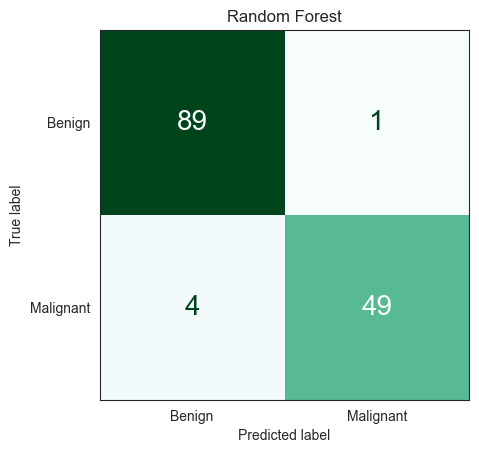

In [59]:
#confusion matrix on pipeline_lgbm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = df_model_rfe.model.values[0].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
#set cmap to "Blues", and label 0 to benign and 1 to malignant
cm_display = cm_display.plot(cmap="BuGn", xticks_rotation="horizontal")
cm_display.ax_.set_xticklabels(["Benign", "Malignant"])
cm_display.ax_.set_yticklabels(["Benign", "Malignant"])
#hide colorbar
cm_display.im_.colorbar.remove()
#set title to "LightGBM"
cm_display.ax_.set_title("Random Forest")
#set fontsize in each cell to 20
for text in cm_display.text_.ravel():
    text.set_fontsize(20)